<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Importation des modules necessaires</p>

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Chargement de la base de données</p>

In [3]:
df = pd.read_csv('Data/laptop_data.csv', index_col = 0)
display(df.head(2))
display(df.info())

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232


<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


None

Le jeu de données fourni contient 1303 observations réparties sur 11 variables, décrites comme suit :

    Company : le nom du fabricant de l'ordinateur (type : chaîne de caractères).
    TypeName : le type d'ordinateur (type : chaîne de caractères).
    Inches : la taille de l'écran de l'ordinateur en pouces (type : flottant).
    ScreenResolution : la résolution de l'écran (type : chaîne de caractères).
    Cpu : le processeur de l'ordinateur (type : chaîne de caractères).
    Ram : la capacité de mémoire vive (RAM) de l'ordinateur (type : chaîne de caractères).
    Memory : la capacité de stockage (mémoire) de l'ordinateur (type : chaîne de caractères).
    Gpu : la carte graphique de l'ordinateur (type : chaîne de caractères).
    OpSys : le système d'exploitation de l'ordinateur (type : chaîne de caractères).
    Weight : le poids de l'ordinateur en kilogrammes (type : chaîne de caractères).
    Price : le prix de l'ordinateur (type : flottant).

Cela constitue la structure de base de notre jeu de données.

<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Nettoyage et exploitation des données</p>

In [84]:
# identification of missing values
display(df.isna().sum())

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

On peut donc observer que notre jeu de données ne contient aucune valeur manquante pour aucune des variables. Cela signifie que toutes les observations sont complètes et qu'il n'est pas nécessaire de traiter des valeurs absentes avant d'analyser ou de modéliser les données.

In [4]:
# Transform 'Ram' to extract only the RAM size and convert it to an integer
df['Ram'] = df['Ram'].str[: -2].astype(int)  # Remove the last two characters (GB or MB) and convert to integer
# Transform 'Weight' to extract only the numeric value and convert it to float
df['Weight'] = df['Weight'].str[: -2].astype(float)  # Remove the last two characters (kg) and convert to float

# Extract the screen width from the 'ScreenResolution' column
df['Screen Width'] = df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[0].astype(int)  # Get width from resolution (e.g., "1920x1080" → "1920")
# Extract the screen height from the 'ScreenResolution' column
df['Screen Height'] = df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[1].astype(int)  # Get height from resolution (e.g., "1920x1080" → "1080")
df = df.drop('ScreenResolution', axis = 1)  # Drop the 'ScreenResolution' column

# Extract the CPU frequency and keep only the numeric value
df['Frequency'] = df['Cpu'].str.split(' ').str[-1]  # Get the last word (e.g., "3.5GHz")
# Remove the 'GHz' suffix and convert the frequency to a float
df['Frequency'] = df['Frequency'].str[: -3].astype(float)  # Remove the 'GHz' and convert to float

# Extract the CPU brand (first word)
df['Cpu Brand'] = df['Cpu'].str.split(' ').str[0]  # Get the first word (e.g., "Intel")
df = df.drop('Cpu', axis = 1)

# Extract the GPU brand (first word)
df['Gpu Brand'] = df['Gpu'].str.split(' ').str[0]  # Get the first word (e.g., "NVIDIA")
df = df.drop('Gpu', axis = 1)

# Split the 'Memory' column into 'Memory Size' and 'Memory Type'
df['Memory Size'] = df['Memory'].str.split(' ').str[0]  # Get the size part (e.g., "8GB")
df['Memory Type'] = df['Memory'].str.split(' ').str[1]  # Get the type part (e.g., "SSD")
df = df.drop('Memory', axis = 1)  # Drop the 'Memory' column
# Function to convert memory size to MB
def convert_into_MB(value):
    if 'GB' in value:
        return float(value.replace('GB', '').strip()) * 1024  # Convert GB to MB
    elif 'T' in value:
        return float(value.replace('TB', '').strip()) * 1048576  # Convert TB to MB
    else:
        return np.na  # Return NaN for unknown units
# Apply the conversion function to the 'Memory Size' column
df['Memory Size'] = df['Memory Size'].apply(convert_into_MB)  # Apply conversion to MB

df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price,Screen Width,Screen Height,Frequency,Cpu Brand,Gpu Brand,Memory Size,Memory Type
0,Apple,Ultrabook,13.3,8,macOS,1.37,71378.6832,2560,1600,2.3,Intel,Intel,131072.0,SSD
1,Apple,Ultrabook,13.3,8,macOS,1.34,47895.5232,1440,900,1.8,Intel,Intel,131072.0,Flash
2,HP,Notebook,15.6,8,No OS,1.86,30636.0000,1920,1080,2.5,Intel,Intel,262144.0,SSD
3,Apple,Ultrabook,15.4,16,macOS,1.83,135195.3360,2880,1800,2.7,Intel,AMD,524288.0,SSD
4,Apple,Ultrabook,13.3,8,macOS,1.37,96095.8080,2560,1600,3.1,Intel,Intel,262144.0,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,33992.6400,1920,1080,2.5,Intel,Intel,131072.0,SSD
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,79866.7200,3200,1800,2.5,Intel,Intel,524288.0,SSD
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,12201.1200,1366,768,1.6,Intel,Intel,65536.0,Flash
1301,HP,Notebook,15.6,6,Windows 10,2.19,40705.9200,1366,768,2.5,Intel,AMD,1048576.0,HDD


In [86]:
# Dataset overview
df.describe()

,Inches,Ram,Weight,Price,Screen Width,Screen Height,Frequency,Memory Size
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1.303000e+03
mean,15.017191,8.382195,2.038734,59870.042910,1894.784344,1070.830391,2.298772,4.585571e+05
std,1.426304,5.084665,0.665475,37243.201786,494.641028,284.519410,0.506340,3.748221e+05
min,10.100000,2.000000,0.690000,9270.720000,1366.000000,768.000000,0.900000,8.192000e+03
25%,14.000000,4.000000,1.500000,31914.720000,1600.000000,900.000000,2.000000,2.621440e+05
50%,15.600000,8.000000,2.040000,52054.560000,1920.000000,1080.000000,2.500000,2.621440e+05
75%,15.600000,8.000000,2.300000,79274.246400,1920.000000,1080.000000,2.700000,5.242880e+05
max,18.400000,64.000000,4.700000,324954.720000,3840.000000,2160.000000,3.600000,2.097152e+06


D'après ce tableau, il est facile de constater qu'il n'y a pas de valeurs aberrantes. Les ordinateurs ayant une taille d'écran de 18 pouces peuvent être expliqués par le fait qu'il s'agit généralement d'ordinateurs de bureau, comme le montre une vérification sur Internet. Quant aux ordinateurs dont le prix dépasse les 324 954 euros, il s'agit principalement de modèles gaming, qui se caractérisent par une grande capacité de RAM, de mémoire et une fréquence élevée, entre autres spécificités.

<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Exploration et analyse des données</p>

Étant donné que les modèles de machine learning ne fonctionnent qu'avec des valeurs numériques, nous sélectionnons uniquement les variables numériques, tout en incluant la variable 'Company' (correspondant à la marque de l'ordinateur). Celle-ci sera convertie en une représentation numérique ultérieurement à l'aide de méthodes comme le One-Hot Encoding ou le Label Encoding, afin de refléter le choix des marques d'ordinateurs disponibles sur le marché.

In [5]:
df.rename(columns = {
    'Memory Size' : 'Memory_size',
    'Screen Width' : 'Screen_width',
    'Screen Height' : 'Screen_height'
}, inplace = True)
limited_df = df.select_dtypes(include = 'number')
limited_df = pd.concat([limited_df, df['Company']], axis = 1)
limited_df

,Inches,Ram,Weight,Price,Screen_width,Screen_height,Frequency,Memory_size,Company
0,13.3,8,1.37,71378.6832,2560,1600,2.3,131072.0,Apple
1,13.3,8,1.34,47895.5232,1440,900,1.8,131072.0,Apple
2,15.6,8,1.86,30636.0000,1920,1080,2.5,262144.0,HP
3,15.4,16,1.83,135195.3360,2880,1800,2.7,524288.0,Apple
4,13.3,8,1.37,96095.8080,2560,1600,3.1,262144.0,Apple
...,...,...,...,...,...,...,...,...,...
1298,14.0,4,1.80,33992.6400,1920,1080,2.5,131072.0,Lenovo
1299,13.3,16,1.30,79866.7200,3200,1800,2.5,524288.0,Lenovo
1300,14.0,2,1.50,12201.1200,1366,768,1.6,65536.0,Lenovo
1301,15.6,6,2.19,40705.9200,1366,768,2.5,1048576.0,HP


Nous calculons la matrice de corrélation entre toutes les colonnes du DataFrame et la colonne 'Price'.

Cela permet de mettre en évidence les variables ayant une corrélation significative avec 'Price'.

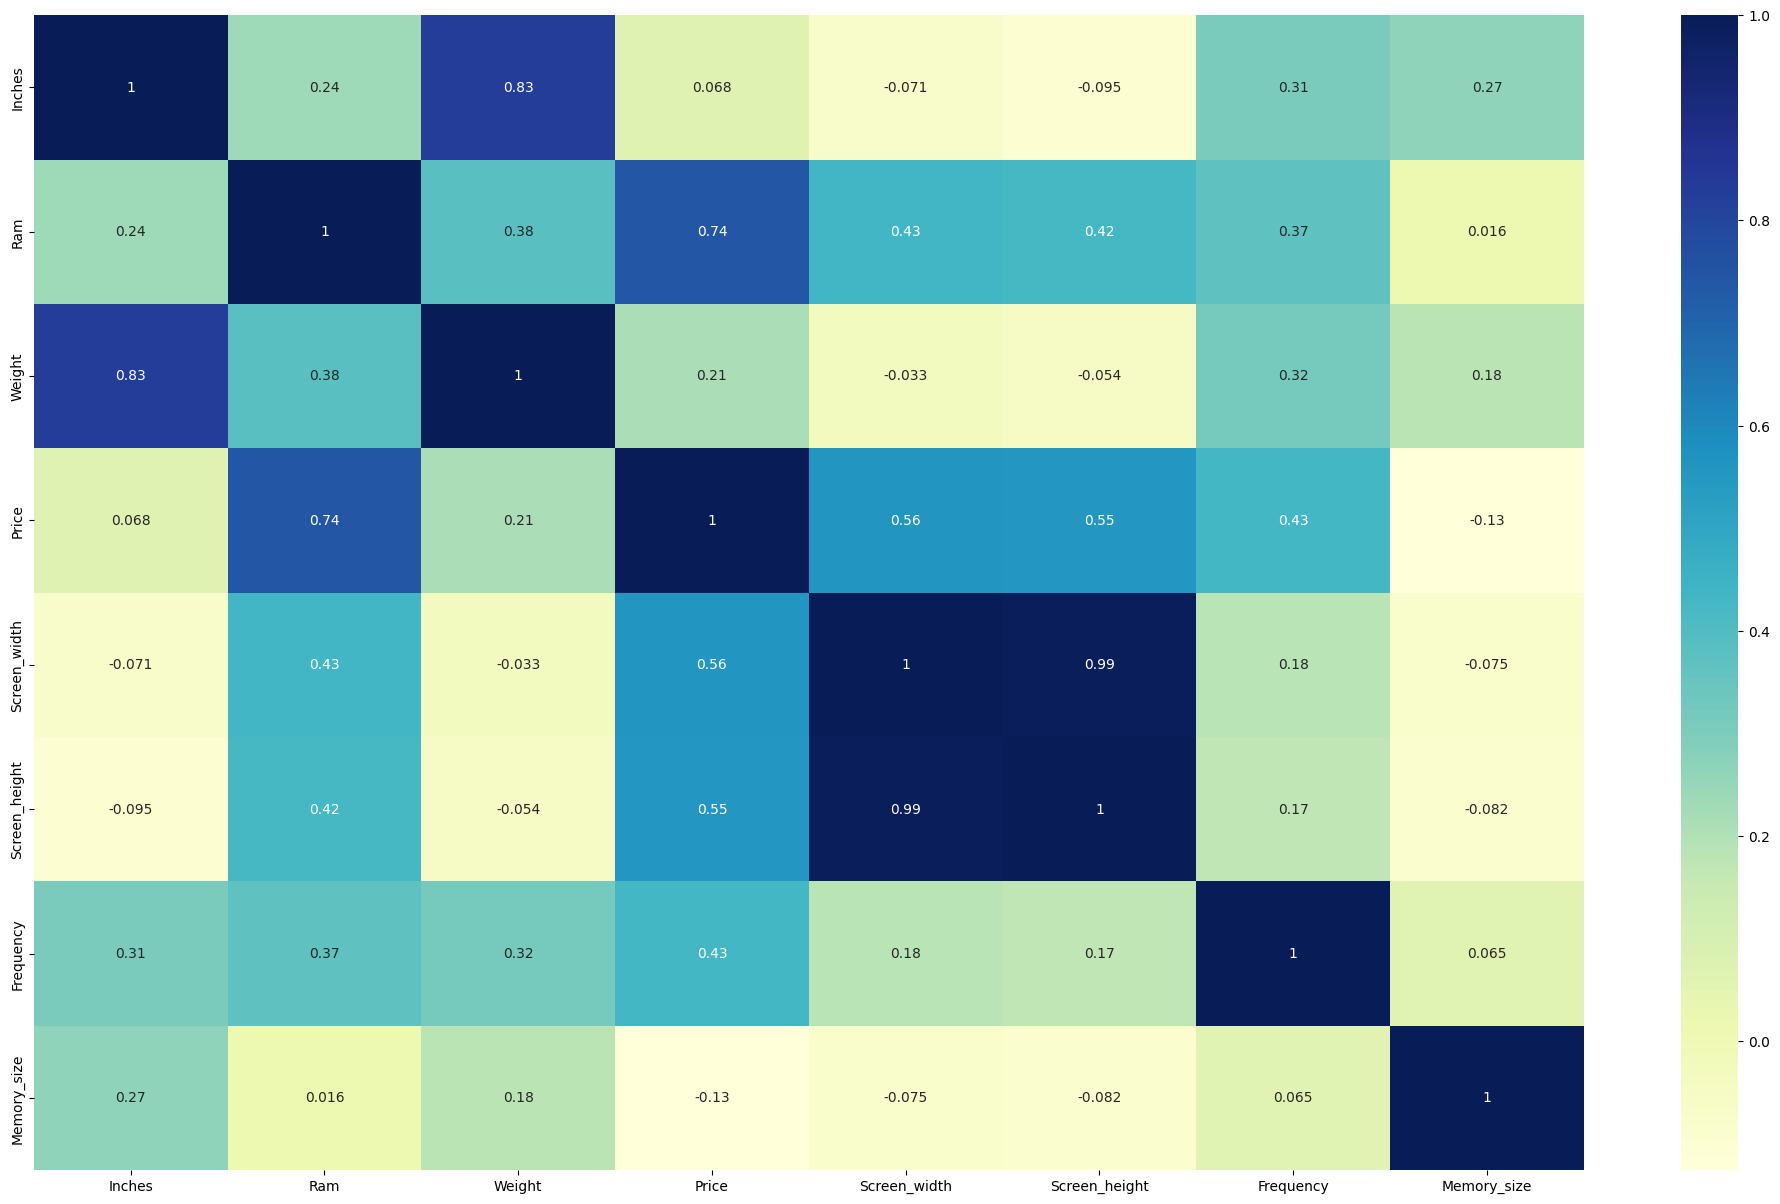

In [89]:
fig = plt.figure(figsize = (25, 15))
sns.heatmap(data = limited_df.select_dtypes(include = 'number').corr(), annot = True, cmap = 'YlGnBu')
plt.show()

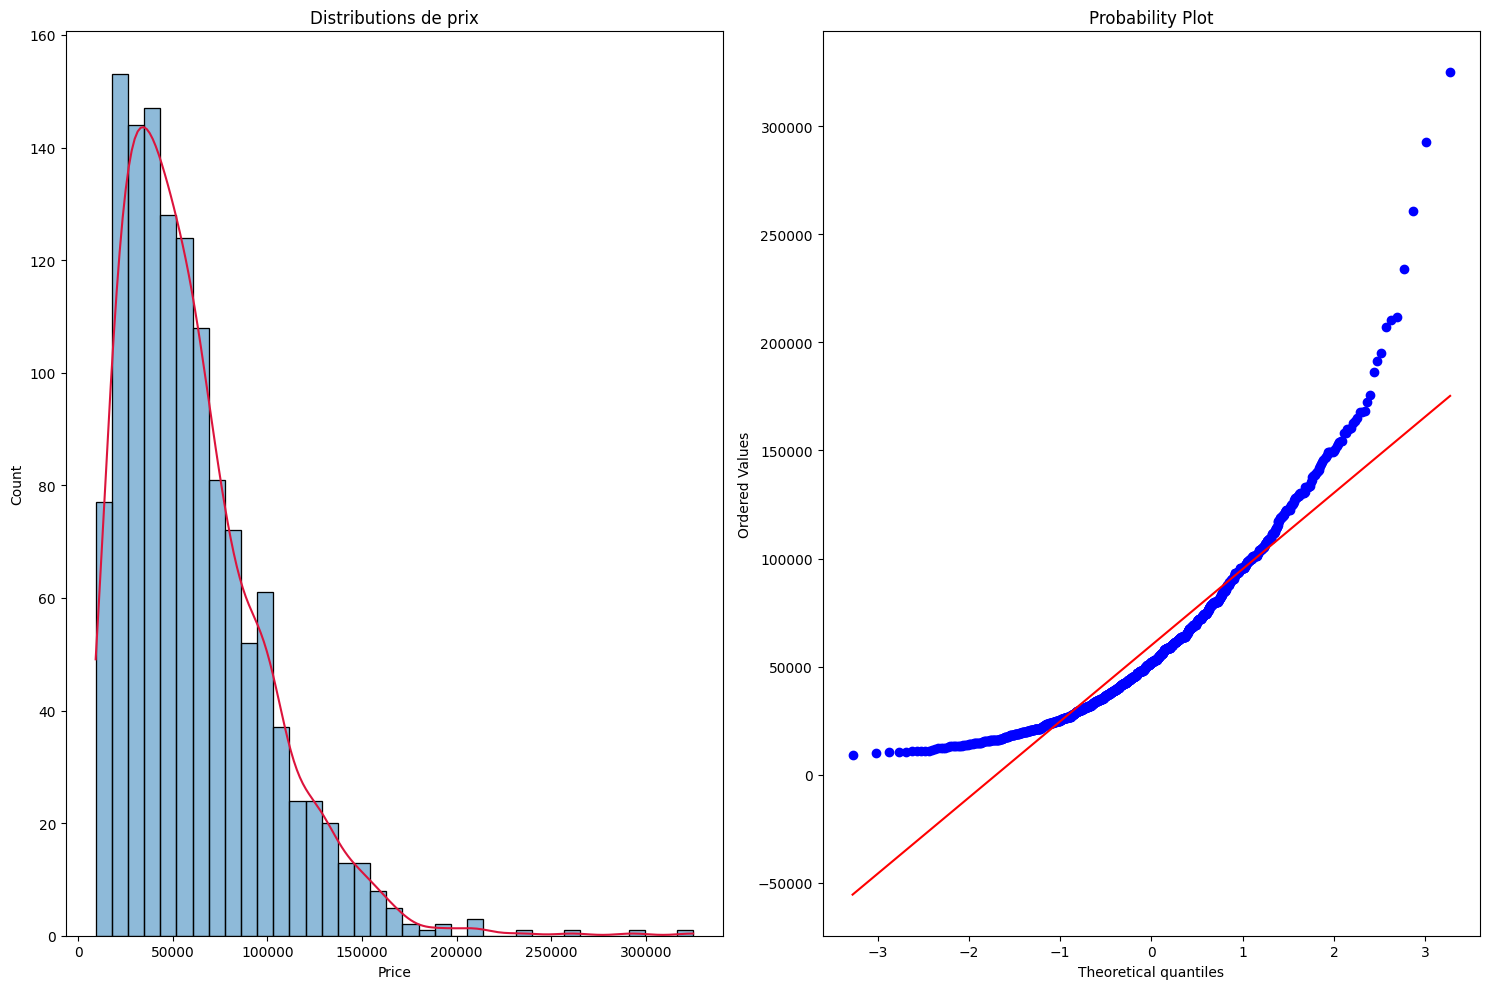

In [90]:
fig, axes = plt.subplots(1, 2, figsize = (15, 10))

sns.histplot(data = limited_df['Price'], kde = True, ax = axes[0])
axes[0].lines[0].set_color('crimson')
axes[0].set_title('Distributions de prix')

axes[1] = stats.probplot(limited_df['Price'], dist = 'norm', plot = plt)

plt.tight_layout()
plt.show()

Au vue de ces graphes ci-dessous, on dire que la distribution des prix d'ordinateurs ne suit pas une distrubition normale; que l'on va verifier grace a 
quelques tests tel que :
le coefficient de skewness : on sait que le coefficient de skewness (qui mesure la symetrie) d'une distribution normale est egal a 0
le coefficient de Kurtoisis : on sait que le coefficient de Kuroisis (qui mesure l'applatissement) d'une distribution normale est egal a 3

In [91]:
skewness = stats.skew(limited_df['Price'])
kurtoisis = stats.kurtosis(limited_df['Price'], fisher = False)
print(f'Le coefficient de skewness est egal a {skewness}')
print(f'Le coefficient de Kuroisis est egal a {kurtoisis}')

Le coefficient de skewness est egal a 1.5191142034364629
Le coefficient de Kuroisis est egal a 7.349729901222108


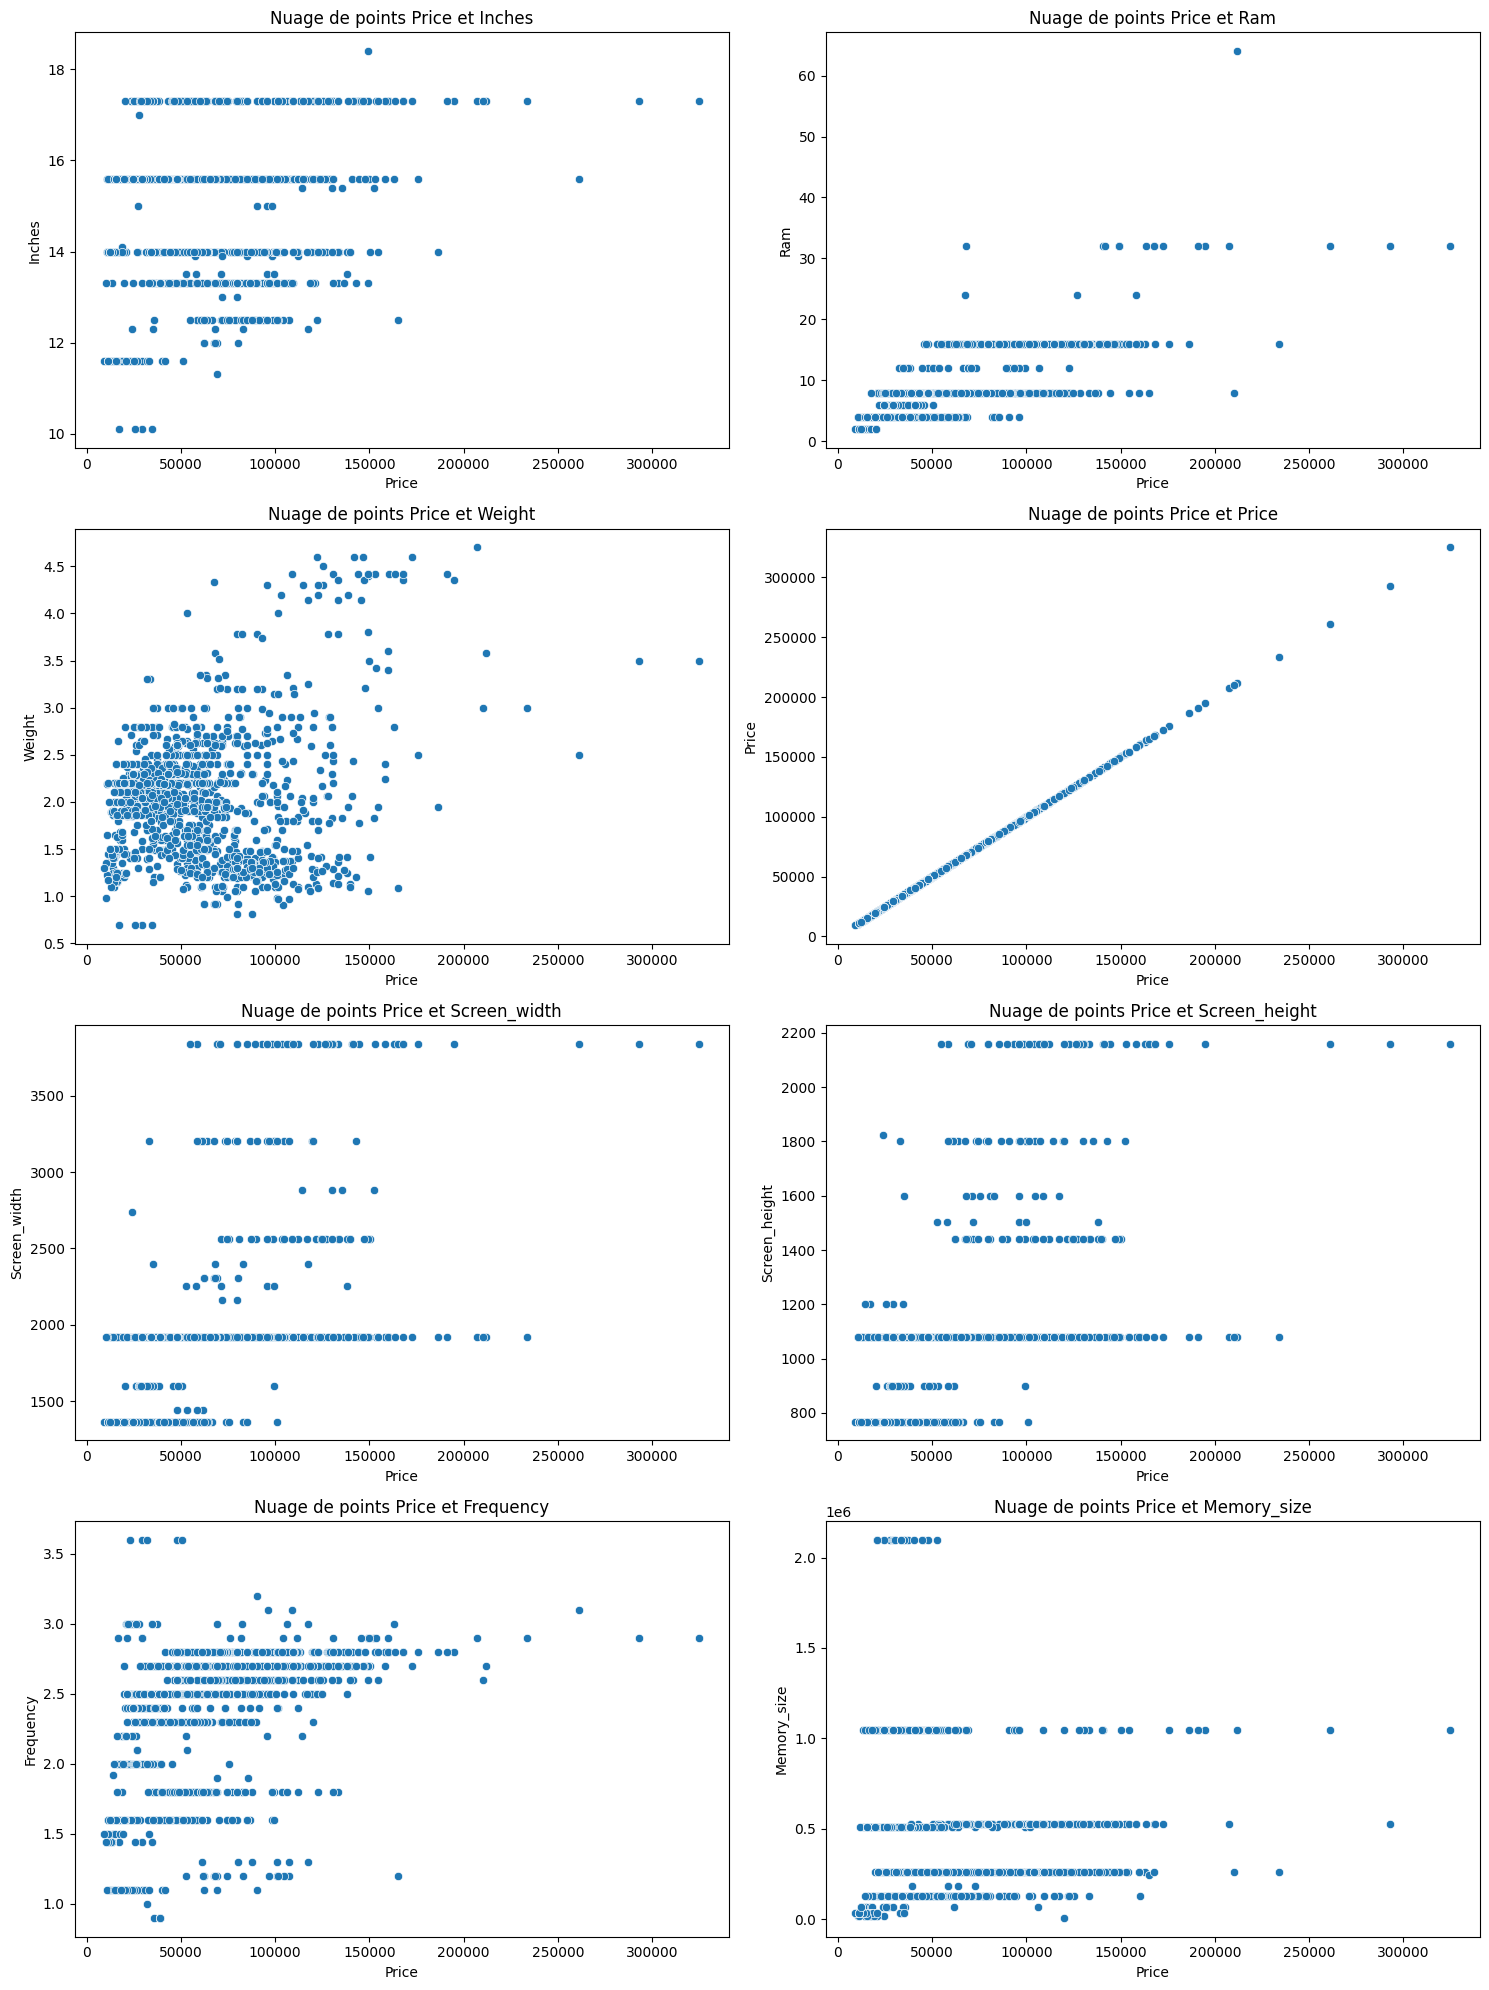

In [99]:
fig, axes = plt.subplots(4, 2, figsize = (15, 20))

for index, column in enumerate(limited_df.select_dtypes(include = 'number').columns) :
    sns.scatterplot(data = limited_df, x = 'Price', y = column, ax = axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_title(f'Nuage de points Price et {column}')
    
plt.tight_layout()
plt.show()

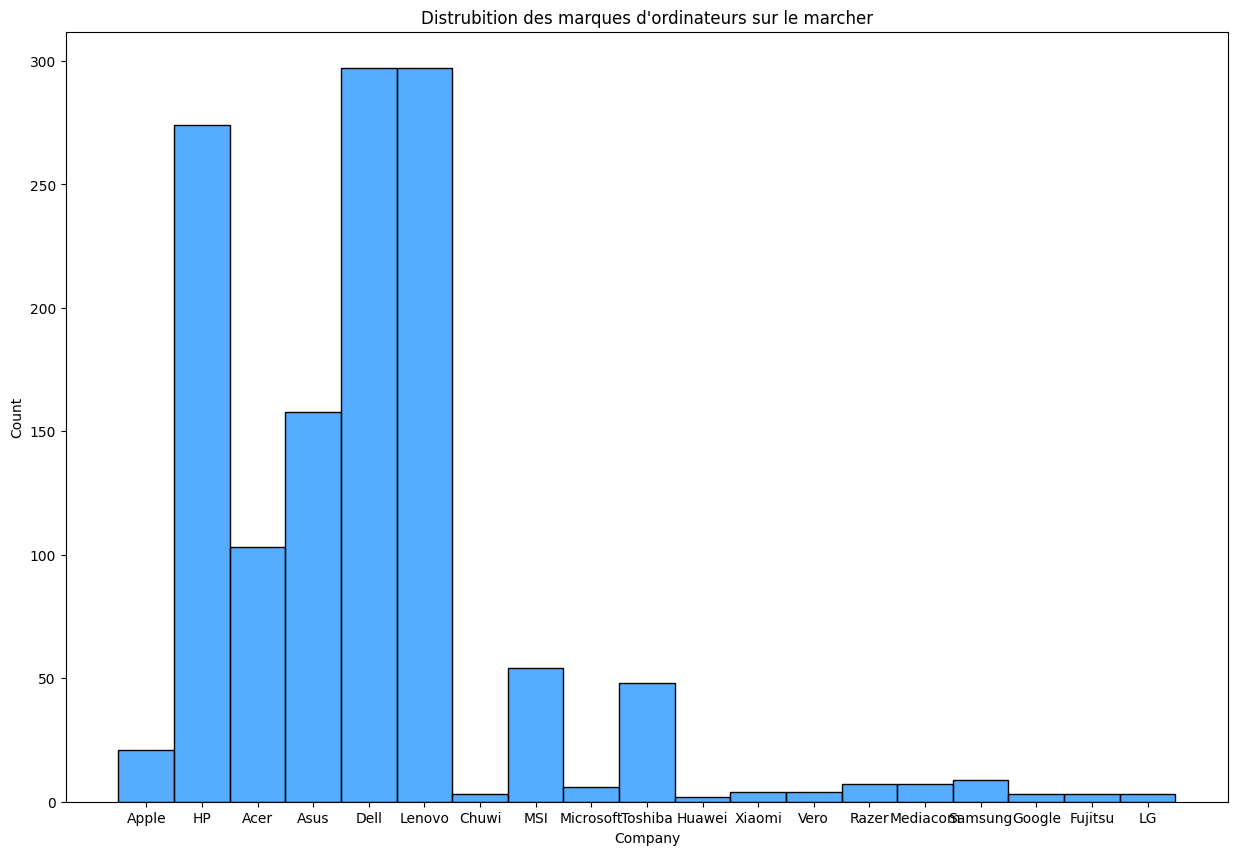

In [108]:
fig = plt.figure(figsize = (15, 10))
sns.histplot(data = limited_df, x = 'Company', color = 'dodgerblue')
plt.title('Distrubition des marques d\'ordinateurs sur le marcher')
plt.show()

D'après ces graphiques, aucune des variables caractéristiques (features) ne semble présenter de relation linéaire évidente avec la variable cible, le prix. Cela suggère que les modèles linéaires pourraient ne pas être les plus adaptés pour résoudre ce problème. Il serait néanmoins intéressant d'explorer plus en profondeur les relations entre les caractéristiques et la variable cible à l'aide de tests statistiques tels que le test de Shapiro, qui permet d'évaluer la normalité des variables via leur p-value.

Par ailleurs, les marques comme HP, Dell, et Lenovo dominent le marché avec des distributions nettement supérieures à celles d'autres marques telles que Apple, Acer, ou Asus. Ce déséquilibre pourrait influencer les valeurs numériques lors de la transformation de cette variable (par exemple, via le One-Hot Encoding ou le Label Encoding), selon la méthode choisie. Il sera important de prendre en compte cette disparité pour éviter tout biais dans le modèle.

In [109]:
for column in limited_df.select_dtypes(include = 'number').columns :
    _, p_value = stats.shapiro(limited_df[column])
    if p_value < 0.05 :
        print(f'P-value de la  normalité (Shapiro-wilk) pour la variable {column} est : {p_value}')

P-value de la  normalité (Shapiro-wilk) pour la variable Inches est : 6.810711858612796e-31
P-value de la  normalité (Shapiro-wilk) pour la variable Ram est : 1.9729656813867227e-42
P-value de la  normalité (Shapiro-wilk) pour la variable Weight est : 1.2811032902304129e-25
P-value de la  normalité (Shapiro-wilk) pour la variable Price est : 4.688363475796598e-29
P-value de la  normalité (Shapiro-wilk) pour la variable Screen_width est : 7.906567027465655e-46
P-value de la  normalité (Shapiro-wilk) pour la variable Screen_height est : 2.2892835167881434e-45
P-value de la  normalité (Shapiro-wilk) pour la variable Frequency est : 2.791801467001679e-29
P-value de la  normalité (Shapiro-wilk) pour la variable Memory_size est : 9.076493540793472e-39


Au vu des valeurs p-value des différentes variables, on peut aisément rejeter l'hypothèse selon laquelle elles suivent une distribution normale, 
car ces p-values sont inférieures au seuil de significativité de 0,05. 
Cependant, il est possible d'examiner s'il existe une relation monotone forte entre ces variables et la variable cible en utilisant le test de Spearman.

In [110]:
for column in limited_df.select_dtypes(include = 'number').columns :
    _, p_value = stats.spearmanr(limited_df['Price'], limited_df[column])
    if p_value < 0.05 :
        print(f'Il y\' a une forte relation monotone entre la variable Price et {column} car p-value = {p_value}')
    else :
        print(f'Il n\'y a pas de relation monotone forte entre la variable Price et {column} car p-value = {p_value}')

Il n'y a pas de relation monotone forte entre la variable Price et Inches car p-value = 0.0916405621260066
Il y' a une forte relation monotone entre la variable Price et Ram car p-value = 2.227782211034968e-255
Il n'y a pas de relation monotone forte entre la variable Price et Weight car p-value = 0.3904266279447126
Il y' a une forte relation monotone entre la variable Price et Price car p-value = 0.0
Il y' a une forte relation monotone entre la variable Price et Screen_width car p-value = 2.9180606434221587e-147
Il y' a une forte relation monotone entre la variable Price et Screen_height car p-value = 2.6065065003868453e-141
Il y' a une forte relation monotone entre la variable Price et Frequency car p-value = 2.171205826040976e-94
Il n'y a pas de relation monotone forte entre la variable Price et Memory_size car p-value = 0.274482290112127


<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Entraînement de modèles</p>

Nous commençons par transformer la variable 'Company' en variable numérique à l'aide de la méthode Label Encoding. Bien que cette méthode établisse un ordre implicite entre les différentes modalités, elle est préférée ici, car l'utilisation du One-Hot Encoding augmenterait considérablement la taille du dataset en raison du grand nombre de modalités.

Ensuite, nous divisons le jeu de données en deux ensembles :

    70 % des données sont affectées à l'entraînement.
    30 % des données sont utilisées pour les tests.

Le paramètre random_state est spécifié pour assurer la reproductibilité de cette division.

Enfin, nous normalisons les données à l'aide de StandardScaler. Cette étape consiste à recentrer les données autour d'une moyenne de 0 et à les redimensionner avec un écart-type de 1, ce qui est essentiel pour garantir que toutes les caractéristiques contribuent équitablement à l'entraînement des modèles, en particulier ceux sensibles aux échelles des variables (comme les modèles linéaires ou les méthodes basées sur les distances).

In [6]:
encoder = LabelEncoder()
encoded_df = limited_df.copy()
encoded_df['Company'] = encoder.fit_transform(encoded_df['Company'])
encoded_df

,Inches,Ram,Weight,Price,Screen_width,Screen_height,Frequency,Memory_size,Company
0,13.3,8,1.37,71378.6832,2560,1600,2.3,131072.0,1
1,13.3,8,1.34,47895.5232,1440,900,1.8,131072.0,1
2,15.6,8,1.86,30636.0000,1920,1080,2.5,262144.0,7
3,15.4,16,1.83,135195.3360,2880,1800,2.7,524288.0,1
4,13.3,8,1.37,96095.8080,2560,1600,3.1,262144.0,1
...,...,...,...,...,...,...,...,...,...
1298,14.0,4,1.80,33992.6400,1920,1080,2.5,131072.0,10
1299,13.3,16,1.30,79866.7200,3200,1800,2.5,524288.0,10
1300,14.0,2,1.50,12201.1200,1366,768,1.6,65536.0,10
1301,15.6,6,2.19,40705.9200,1366,768,2.5,1048576.0,7


In [7]:
for original, encoded_value in zip(encoder.classes_, range(len(encoder.classes_))) :
    print(f'{original} encodé en {encoded_value}')

Acer encodé en 0
Apple encodé en 1
Asus encodé en 2
Chuwi encodé en 3
Dell encodé en 4
Fujitsu encodé en 5
Google encodé en 6
HP encodé en 7
Huawei encodé en 8
LG encodé en 9
Lenovo encodé en 10
MSI encodé en 11
Mediacom encodé en 12
Microsoft encodé en 13
Razer encodé en 14
Samsung encodé en 15
Toshiba encodé en 16
Vero encodé en 17
Xiaomi encodé en 18


In [8]:
X, y = encoded_df.drop('Price', axis = 1), encoded_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, test_size = 0.30, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

<p style = 'text-align : center; font-weight : bold; font-size : 20px; color : dodgerblue;'>Modèle KNN</p>

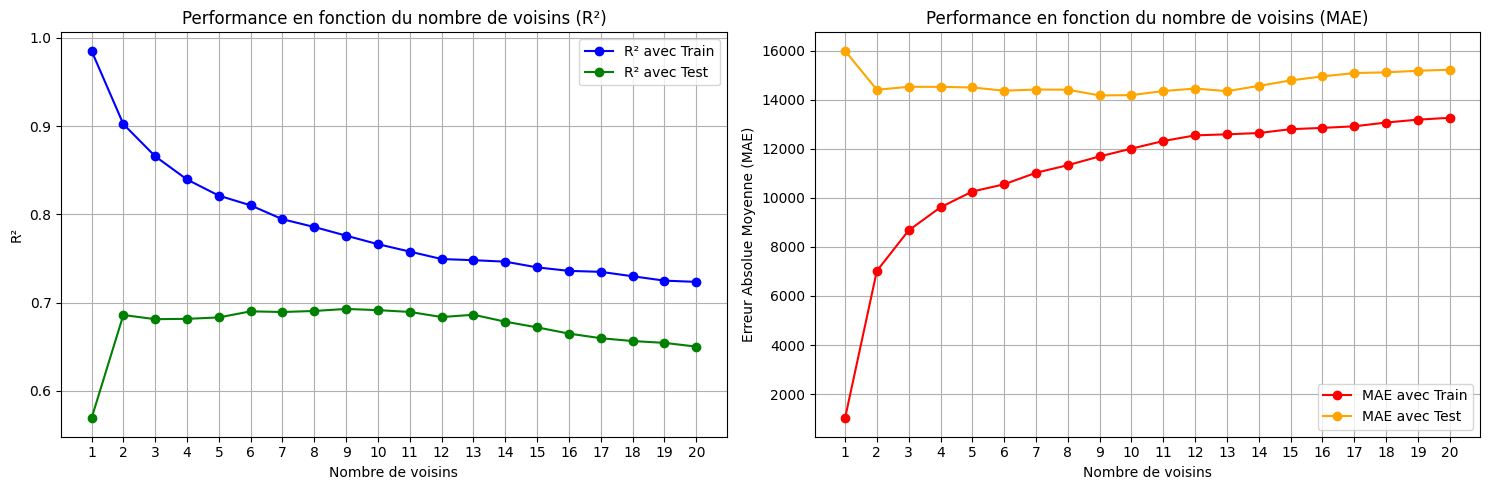

Best parameters :  {'n_neighbors': 5}
R² avec Train : 0.821
R² avec Test : 0.683
MAE avec Train : 10257.095
MAE avec Test : 14496.323


In [9]:
neighbors = list(range(1, 21))
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
train_mae = np.empty(len(neighbors))
test_mae = np.empty(len(neighbors))

for index, neighbor in enumerate(neighbors) :
    knn = KNeighborsRegressor(n_neighbors = neighbor)
    knn.fit(X_train_scaled, y_train)
    
    train_accuracy[index] = knn.score(X_train_scaled, y_train)
    test_accuracy[index] = knn.score(X_test_scaled, y_test)
    
    train_mae[index] = mean_absolute_error(y_train, knn.predict(X_train_scaled))
    test_mae[index] = mean_absolute_error(y_test, knn.predict(X_test_scaled))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(neighbors, train_accuracy, 'o-', label = 'R² avec Train', color = 'blue')
ax1.plot(neighbors, test_accuracy, 'o-', label = 'R² avec Test', color = 'green')
ax1.set_xlabel('Nombre de voisins')
ax1.set_ylabel('R²')
ax1.set_title('Performance en fonction du nombre de voisins (R²)')
ax1.set_xticks(neighbors)
ax1.legend(loc = 'upper right')
ax1.grid()

ax2.plot(neighbors, train_mae, 'o-', label = 'MAE avec Train', color = 'red')
ax2.plot(neighbors, test_mae, 'o-', label = 'MAE avec Test', color = 'orange')
ax2.set_xlabel('Nombre de voisins')
ax2.set_ylabel('Erreur Absolue Moyenne (MAE)')
ax2.set_title('Performance en fonction du nombre de voisins (MAE)')
ax2.set_xticks(neighbors)
ax2.legend(loc = 'lower right')
ax2.grid()

plt.tight_layout()
plt.show()

param_grid = {
    'n_neighbors': neighbors,
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv = 5, scoring = 'r2')
grid_search.fit(X_train_scaled, y_train)
print("Best parameters : ", grid_search.best_params_)

best_knn = grid_search.best_estimator_
train_accuracy = best_knn.score(X_train_scaled, y_train)
test_accuracy = best_knn.score(X_test_scaled, y_test)
train_mae = mean_absolute_error(y_train, best_knn.predict(X_train_scaled))
test_mae = mean_absolute_error(y_test, best_knn.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")

<p style = 'text-align : center; font-weight : bold; font-size : 20px; color : dodgerblue;'>Modèle Random Forest Regressor</p>

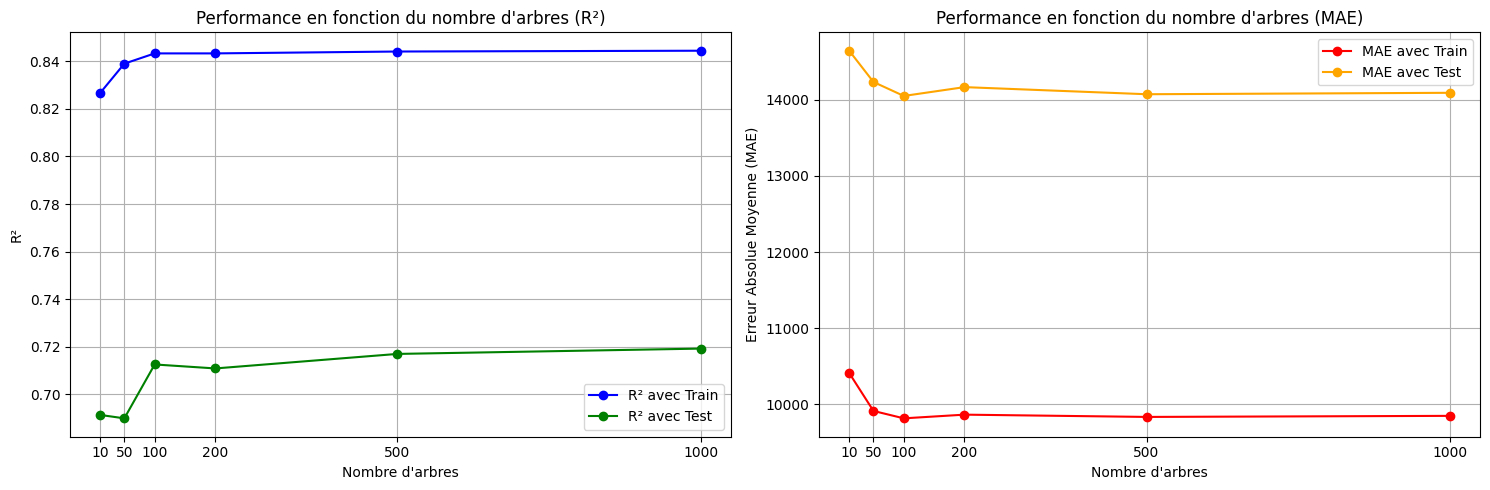

Best parameters :  {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 1000}
R² avec Train : 0.857
R² avec Test : 0.727
MAE avec Train : 9337.850
MAE avec Test : 13801.782


In [10]:
# trees = list(range(100, 701, 100))
trees = [10, 50, 100, 200, 500, 1000]
train_accuracy = np.empty(len(trees))
test_accuracy = np.empty(len(trees))
train_mae = np.empty(len(trees))
test_mae = np.empty(len(trees))

for index, tree in enumerate(trees) :
    forest = RandomForestRegressor(n_estimators = tree, max_features = 'sqrt', max_depth = 7, random_state = 42)
    forest.fit(X_train_scaled, y_train)

    train_accuracy[index] = forest.score(X_train_scaled, y_train)
    test_accuracy[index] = forest.score(X_test_scaled, y_test)

    train_mae[index] = mean_absolute_error(y_train, forest.predict(X_train_scaled))
    test_mae[index] = mean_absolute_error(y_test, forest.predict(X_test_scaled))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(trees, train_accuracy, 'o-', label = 'R² avec Train', color = 'blue')
ax1.plot(trees, test_accuracy, 'o-', label = 'R² avec Test', color = 'green')
ax1.set_xlabel('Nombre d\'arbres')
ax1.set_ylabel('R²')
ax1.set_title('Performance en fonction du nombre d\'arbres (R²)')
ax1.set_xticks(trees)
ax1.legend(loc = 'lower right')
ax1.grid()

ax2.plot(trees, train_mae, 'o-', label = 'MAE avec Train', color = 'red')
ax2.plot(trees, test_mae, 'o-', label = 'MAE avec Test', color = 'orange')
ax2.set_xlabel('Nombre d\'arbres')
ax2.set_ylabel('Erreur Absolue Moyenne (MAE)')
ax2.set_title('Performance en fonction du nombre d\'arbres (MAE)')
ax2.set_xticks(trees)
ax2.legend(loc = 'upper right')
ax2.grid()

plt.tight_layout()
plt.show()

param_grid = {
    'n_estimators': trees,
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state = 42), param_grid, cv = 5, scoring = 'r2')
grid_search.fit(X_train_scaled, y_train)
print("Best parameters : ", grid_search.best_params_)

best_forest = grid_search.best_estimator_
train_accuracy = best_forest.score(X_train_scaled, y_train)
test_accuracy = best_forest.score(X_test_scaled, y_test)
train_mae = mean_absolute_error(y_train, best_forest.predict(X_train_scaled))
test_mae = mean_absolute_error(y_test, best_forest.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")

<p style = 'text-align : center; font-weight : bold; font-size : 20px; color : dodgerblue;'>Modèle Support Vector Machine</p>

In [11]:
param_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [0.1, 1, 10, 100],
    'gamma' : ['scale', 'auto']
}

grid_search = GridSearchCV(SVR(), param_grid, cv = 5, scoring = 'r2')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters : ", grid_search.best_params_)

best_svr = grid_search.best_estimator_

train_accuracy = best_svr.score(X_train_scaled, y_train)
test_accuracy = best_svr.score(X_test_scaled, y_test)

train_mae = mean_absolute_error(y_train, best_svr.predict(X_train_scaled))
test_mae = mean_absolute_error(y_test, best_svr.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")

Best parameters :  {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
R² avec Train : 0.634
R² avec Test : 0.580
MAE avec Train : 15305.903
MAE avec Test : 17451.527


<p style = 'text-align : center; font-weight : bold; font-size : 20px; color : dodgerblue;'>Modèle Ridge</p>

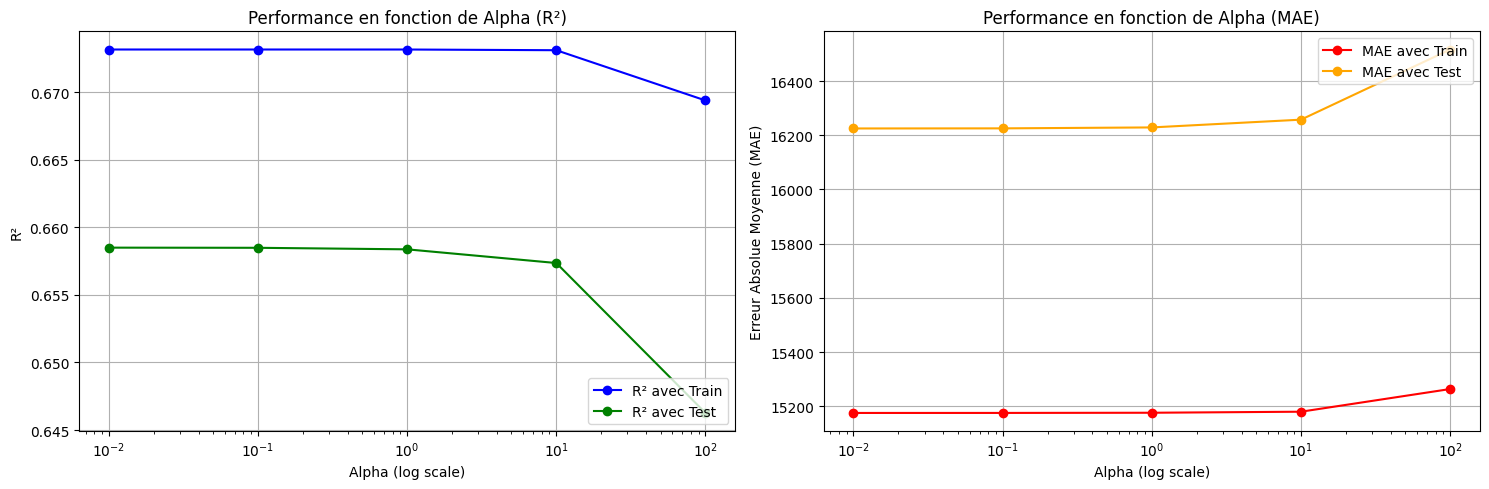

R² avec Train : 0.673
R² avec Test : 0.657
MAE avec Train : 15180.463
MAE avec Test : 16257.506


In [13]:
alphas = [0.01, 0.1, 1, 10, 100]
train_accuracy = np.empty(len(alphas))
test_accuracy = np.empty(len(alphas))
train_mae = np.empty(len(alphas))
test_mae = np.empty(len(alphas))

for index, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha, max_iter = 10000, random_state = 42)
    ridge.fit(X_train_scaled, y_train)

    train_accuracy[index] = ridge.score(X_train_scaled, y_train)
    test_accuracy[index] = ridge.score(X_test_scaled, y_test)

    train_mae[index] = mean_absolute_error(y_train, ridge.predict(X_train_scaled))
    test_mae[index] = mean_absolute_error(y_test, ridge.predict(X_test_scaled))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(alphas, train_accuracy, 'o-', label = 'R² avec Train', color = 'blue')
ax1.plot(alphas, test_accuracy, 'o-', label = 'R² avec Test', color = 'green')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (log scale)')
ax1.set_ylabel('R²')
ax1.set_title('Performance en fonction de Alpha (R²)')
ax1.legend(loc = 'lower right')
ax1.grid()

ax2.plot(alphas, train_mae, 'o-', label = 'MAE avec Train', color = 'red')
ax2.plot(alphas, test_mae, 'o-', label = 'MAE avec Test', color = 'orange')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (log scale)')
ax2.set_ylabel('Erreur Absolue Moyenne (MAE)')
ax2.set_title('Performance en fonction de Alpha (MAE)')
ax2.legend(loc = 'upper right')
ax2.grid()

plt.tight_layout()
plt.show()

param_grid = {'alpha': alphas}
grid_search = GridSearchCV(Ridge(max_iter = 10000, random_state = 42), param_grid, cv = 5, scoring = 'r2')
grid_search.fit(X_train_scaled, y_train)

best_ridge = grid_search.best_estimator_
train_accuracy = best_ridge.score(X_train_scaled, y_train)
test_accuracy = best_ridge.score(X_test_scaled, y_test)
train_mae = mean_absolute_error(y_train, best_ridge.predict(X_train_scaled))
test_mae = mean_absolute_error(y_test, best_ridge.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")

<p style = 'text-align : center; font-weight : bold; font-size : 20px; color : dodgerblue;'>Modèle Linear Regression</p>

In [14]:
linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
train_accuracy = linear.score(X_train_scaled, y_train)
test_accuracy = linear.score(X_test_scaled, y_test)
train_mae = mean_absolute_error(y_train, linear.predict(X_train_scaled))
train_mae = mean_absolute_error(y_test, linear.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")

R² avec Train : 0.673
R² avec Test : 0.658
MAE avec Train : 16225.000
MAE avec Test : 16257.506


<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Validation</p>

Au regard des valeurs de R², du MAE, et des représentations graphiques des performances des différents modèles, le RandomForestRegressor se distingue comme le modèle le plus performant pour ce projet, avec les hyperparamètres suivants : max_depth = 7, max_features = 'log2', et n_estimators = 1000.

R² avec Train : 0.857
R² avec Test : 0.727
MAE avec Train : 9337.850
MAE avec Test : 13801.782


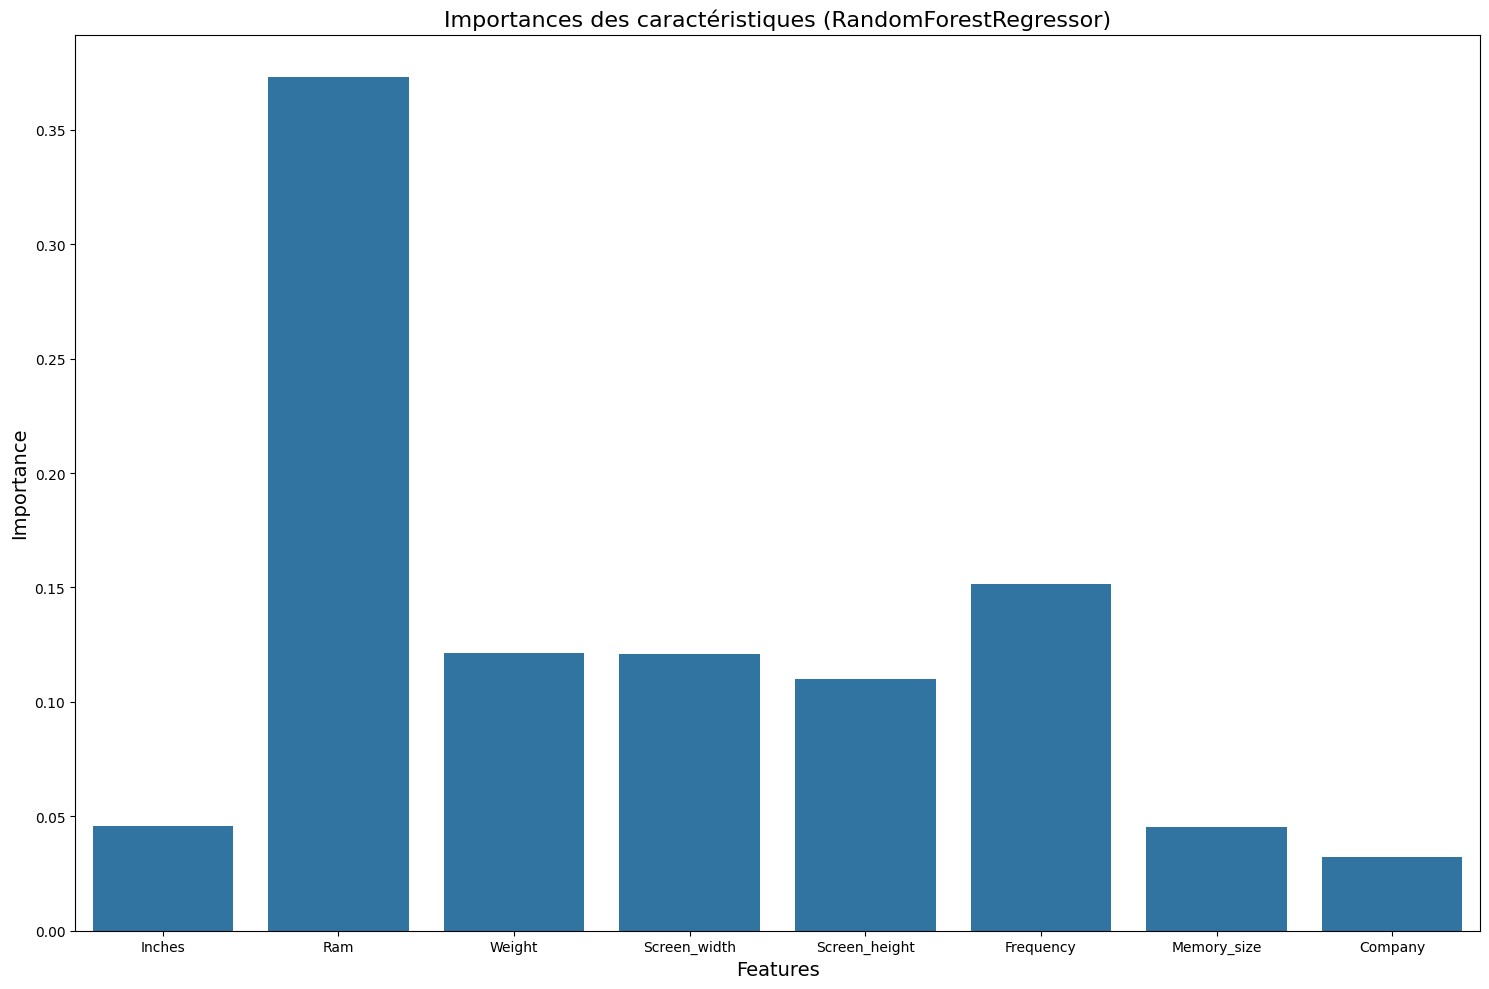

In [15]:
model = RandomForestRegressor(n_estimators = 1000, max_features = 'log2', max_depth = 7, random_state = 42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

feature_importances = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature' : features,
    'Importance' : feature_importances
})
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)
train_mae = mean_absolute_error(y_train, model.predict(X_train_scaled))
test_mae = mean_absolute_error(y_test, model.predict(X_test_scaled))
train_mse = mean_squared_error(y_train, model.predict(X_train_scaled))
test_mse = mean_squared_error(y_test, model.predict(X_test_scaled))
train_rmse = root_mean_squared_error(y_train, model.predict(X_train_scaled))
test_rmse = root_mean_squared_error(y_test, model.predict(X_test_scaled))

print(f"R² avec Train : {train_accuracy:.3f}")
print(f"R² avec Test : {test_accuracy:.3f}")
print(f"MAE avec Train : {train_mae:.3f}")
print(f"MAE avec Test : {test_mae:.3f}")
# print(f"MSE avec Train : {train_mse:.3f}")
# print(f"MSE avec Test : {test_mse:.3f}")
# print(f"RMSE avec Train : {train_rmse:.3f}")
# print(f"RMSE avec Test : {test_rmse:.3f}")

plt.figure(figsize = (15, 10))
sns.barplot(x = importance_df['Feature'], y = importance_df['Importance'])
plt.title("Importances des caractéristiques (RandomForestRegressor)", fontsize = 16)
plt.xlabel("Features", fontsize = 14)
plt.ylabel("Importance", fontsize = 14)
plt.tight_layout()
plt.show()

À la vue de ce graphique, on peut conclure que les caractéristiques telles que la RAM, la hauteur, la taille de l'écran, la fréquence, et le poids sont celles qui expliquent le mieux le prix d'un ordinateur. Ces variables se distinguent par leur importance élevée dans le modèle, ce qui les place parmi les facteurs déterminants influençant le prix.

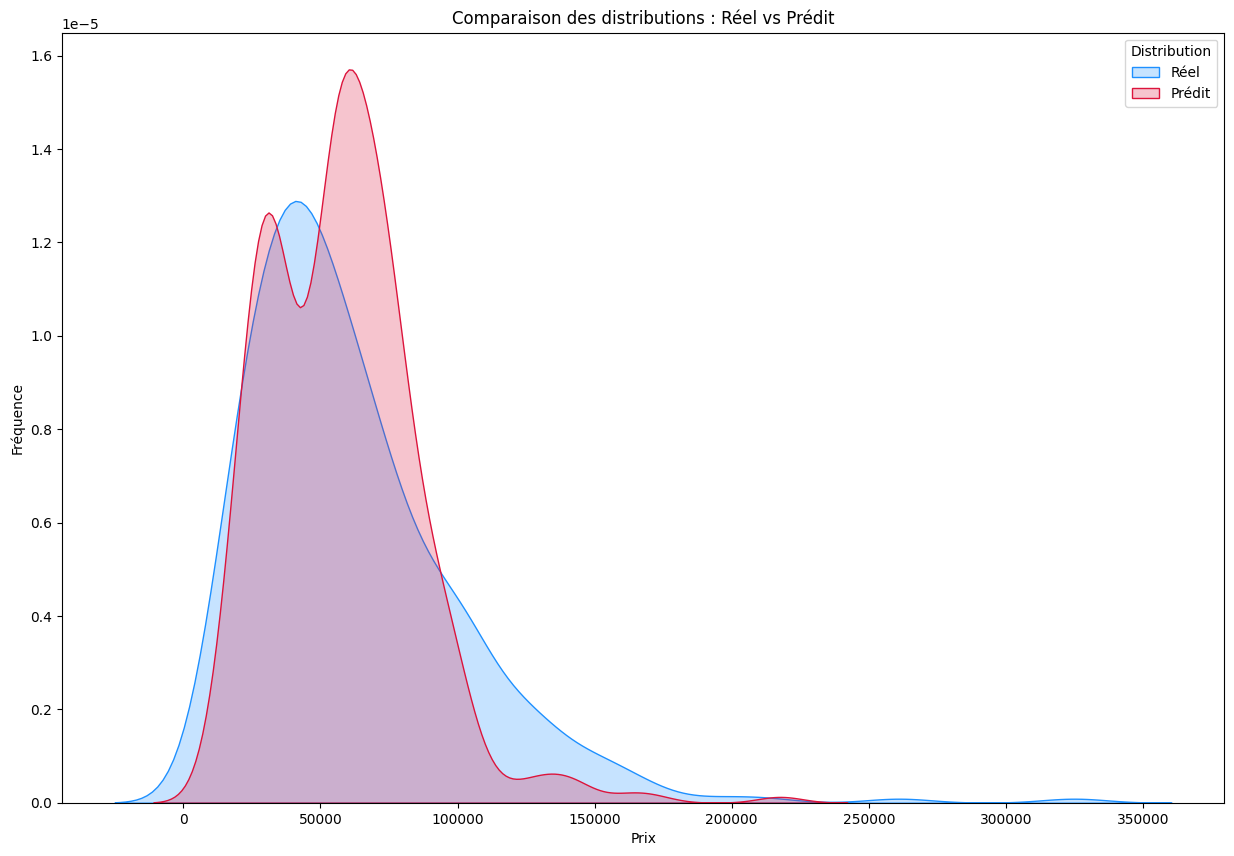

In [16]:
fig = plt.figure(figsize = (15, 10))
sns.kdeplot(y_test, color = 'dodgerblue', label = 'Réel', fill = True)
sns.kdeplot(y_pred, color = 'crimson', label = 'Prédit', fill = True)
plt.title('Comparaison des distributions : Réel vs Prédit')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.legend(title = 'Distribution')
plt.show()

In [17]:
new_data = {
    'Inches' : [13.3],
    'Ram' : [8],
    'Weight' : [1.3],
    'Screen_width' : [2560],
    'Screen_height' : [1600],
    'Frequency' : [2.4],
    'Memory_size' : [131072.0],
    'Company' : ['Lenovo']
}
new_data = pd.DataFrame(new_data)
new_data['Company'] = encoder.transform(new_data['Company'])
new_data_scaled = scaler.transform(new_data)
predicted_price = model.predict(new_data_scaled)
print(f"Le prix prédit est : {predicted_price[0]}")

Le prix prédit est : 82687.44955534197


In [19]:
joblib.dump(model, 'Deploiment/random_forest_model.joblib')
joblib.dump(scaler, 'Deploiment/scaler.joblib')

['Deploiment/scaler.joblib']

In [21]:
loaded_model = joblib.load('Deploiment/random_forest_model.joblib')
predicted_price = loaded_model.predict(new_data_scaled)
print(f"Le prix prédit est : {predicted_price[0]}")

Le prix prédit est : 82687.44955534197


<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Deploiement</p>

Pour le déploiement, nous avons utilisé le microframework Flask pour créer une API et un formulaire HTML stylisé avec Bootstrap. Voici ci-dessous des captures de l'application web :

![capture1](Deploiment/static/cap1.png)

![capture1](Deploiment/static/cap2.png)

![capture1](Deploiment/static/cap3.png)